## Pre-Procesing

In [1]:
from preprocessing import train_valid_test_split, combine_labels, get_attribute_dims

In [2]:
# Train-Test Split Folders
SOURCE_DATA_DIR = "data/ClothingAttributeDataset/images/"
TARGET_DATA_DIR = "data/ClothingAttributeDataset/"

# Labels File
LABEL_DIR = "data/ClothingAttributeDataset/labels/"
labels_file = "data/labels.csv"
label_values_file = "data/label_values.json"

# Train and Validation Images
TRAIN_IMAGES_FOLDER = "data/ClothingAttributeDataset/train/"
VALID_IMAGES_FOLDER = "data/ClothingAttributeDataset/valid/"
TEST_IMAGES_FOLDER = "data/ClothingAttributeDataset/test/"

In [3]:
train_valid_test_split(SOURCE_DATA_DIR, TARGET_DATA_DIR, train_size=0.75, valid_size=0.15)

In [12]:
!ls data/ClothingAttributeDataset/train | wc -l

1392


In [13]:
!ls data/ClothingAttributeDataset/valid | wc -l

278


In [14]:
!ls data/ClothingAttributeDataset/test | wc -l

186


In [6]:
labels_df = combine_labels(LABEL_DIR, labels_file, label_values_file)

In [7]:
# binary_columns = ['skin_exposure_GT', 'collar_GT', 'gender_GT', 'scarf_GT', 'necktie_GT',  'placket_GT']
# multi_columns = ['category_GT', 'neckline_GT', 'sleevelength_GT']
    
# color_columns = ['white_GT', 'yellow_GT', 'gray_GT', 'green_GT', 'blue_GT', 'brown_GT', 'red_GT',
#                  'cyan_GT', 'black_GT', 'purple_GT', 'many_colors_GT']
# pattern_columns = ['pattern_spot_GT', 'pattern_solid_GT', 'pattern_graphics_GT', 
#                   'pattern_plaid_GT', 'pattern_stripe_GT', 'pattern_floral_GT']

## Build Models

In [3]:
from classifiers import get_pretrained_model, create_attributes_fc_model
from utils import is_gpu_available

In [4]:
target_dims = get_attribute_dims(label_values_file)

In [5]:
target_dims

{'category_GT': 7,
 'collar_GT': 2,
 'gender_GT': 2,
 'neckline_GT': 3,
 'necktie_GT': 2,
 'pattern_GT': 6,
 'placket_GT': 2,
 'scarf_GT': 2,
 'skin_exposure_GT': 2,
 'sleevelength_GT': 3}

In [6]:
gender_dims = {"gender_GT": 2}

In [7]:
use_gpu = is_gpu_available()

## Build Dense Models

In [8]:
pretrained_conv, pretrained_fc, fc_dim = get_pretrained_model("resnet18", pop_last_pool_layer=False, use_gpu=use_gpu)

In [9]:
pretrained_conv

Sequential (
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, 

In [10]:
pretrained_fc

Linear (512 -> 1000)

In [11]:
!rm weights/alexnet-test/*

In [12]:
attribute_models = create_attributes_fc_model(pretrained_fc, pretrained_conv, fc_dim, 
                                gender_dims, "weights/alexnet-test",
                                labels_file, 
                                TRAIN_IMAGES_FOLDER, 
                                VALID_IMAGES_FOLDER, 
                                num_epochs=20, 
                                use_gpu=use_gpu,
                                is_train=True)

Processing Attribute: gender_GT
Start Training for: gender_GT
LR is set to 0.01
train Epoch 0/19 Loss: 0.0262 Acc: 0.4725
valid Epoch 0/19 Loss: 0.0271 Acc: 0.4552
train Epoch 5/19 Loss: 0.0151 Acc: 0.8336
valid Epoch 5/19 Loss: 0.0161 Acc: 0.8246
LR is set to 0.001
train Epoch 10/19 Loss: 0.0148 Acc: 0.8484
valid Epoch 10/19 Loss: 0.0163 Acc: 0.8246
LR is set to 0.00010000000000000002
train Epoch 15/19 Loss: 0.0153 Acc: 0.8336
valid Epoch 15/19 Loss: 0.0158 Acc: 0.8321
Training completed in 1.000000m 40.038947s
Best val Acc: 0.854478


In [20]:
attribute_models

{'category_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 7)
   )
 ), 'collar_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 2)
   )
 ), 'gender_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 2)
   )
 ), 'neckline_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (

## Fully FCN Model

In [8]:
pretrained_conv_model, _, _ = get_pretrained_model("vgg16", pop_last_pool_layer=True, use_gpu=use_gpu)

In [9]:
from classifiers import AttributeFCN, create_attributes_model

In [9]:
dict(list(target_dims.items())[:3])

{'gender_GT': 2, 'neckline_GT': 3, 'pattern_GT': 6}

In [10]:
!ls weights/vgg16-fcn-3/

category_GT.pth  neckline_GT.pth  placket_GT.pth	sleevelength_GT.pth
collar_GT.pth	 necktie_GT.pth   scarf_GT.pth
gender_GT.pth	 pattern_GT.pth   skin_exposure_GT.pth


In [11]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
#                                 dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-266-2/",
                                labels_file, 
                                 TRAIN_IMAGES_FOLDER, 
                                 VALID_IMAGES_FOLDER, 
                                 num_epochs=1, 
                                 is_train=True,
                                 use_gpu=use_gpu)

Processing Attribute: category_GT
Start Training for: category_GT
LR is set to 0.01
train Epoch 0/0 Loss: 0.0210 Acc: 0.7903
valid Epoch 0/0 Loss: 0.0226 Acc: 0.7403
Training completed in 0.000000m 13.875891s
Best val Acc: 0.740260
Processing Attribute: neckline_GT
Start Training for: neckline_GT
LR is set to 0.01
train Epoch 0/0 Loss: 0.0177 Acc: 0.7838
valid Epoch 0/0 Loss: 0.0235 Acc: 0.7306
Training completed in 0.000000m 15.785765s
Best val Acc: 0.730570
Processing Attribute: necktie_GT
Start Training for: necktie_GT
LR is set to 0.01
train Epoch 0/0 Loss: 0.0064 Acc: 0.9215
valid Epoch 0/0 Loss: 0.0052 Acc: 0.9468
Training completed in 0.000000m 20.485661s
Best val Acc: 0.946768
Processing Attribute: scarf_GT
Start Training for: scarf_GT
LR is set to 0.01
train Epoch 0/0 Loss: 0.0047 Acc: 0.9499
valid Epoch 0/0 Loss: 0.0164 Acc: 0.9070
Training completed in 0.000000m 19.654756s
Best val Acc: 0.906977
Processing Attribute: sleevelength_GT
Start Training for: sleevelength_GT
LR is 

In [11]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
#                                 dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-test/",
                                labels_file, 
                                 TRAIN_IMAGES_FOLDER, 
                                 VALID_IMAGES_FOLDER, 
                                 num_epochs=5, 
                                 is_train=True,
                                 use_gpu=use_gpu)

Processing Attribute: scarf_GT
Start Training for: scarf_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0195 Acc: 0.8114
valid Epoch 0/4 Loss: 0.0171 Acc: 0.8347
Training completed in 1.000000m 39.057248s
Best val Acc: 0.875000
Processing Attribute: category_GT
Start Training for: category_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0623 Acc: 0.3644
valid Epoch 0/4 Loss: 0.0604 Acc: 0.4304
Training completed in 1.000000m 8.012913s
Best val Acc: 0.575949
Processing Attribute: necktie_GT
Start Training for: necktie_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0181 Acc: 0.8775
valid Epoch 0/4 Loss: 0.0164 Acc: 0.9046
Training completed in 1.000000m 44.066475s
Best val Acc: 0.950382
Processing Attribute: neckline_GT
Start Training for: neckline_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0342 Acc: 0.4840
valid Epoch 0/4 Loss: 0.0317 Acc: 0.6158
Training completed in 1.000000m 20.402497s
Best val Acc: 0.631579
Processing Attribute: skin_exposure_GT
Start Training for: skin_exposure_GT
LR is

In [ ]:
# attribute_models = create_attributes_model(pretrained_fc, pretrained_conv_model, fc_dim, target_dims, "weights-fcn/",
#                                 labels_file, 
#                                  TRAIN_IMAGES_FOLDER, 
#                                  VALID_IMAGES_FOLDER, 
#                                  num_epochs=1, is_train=True)

## Evaluate the Model

In [8]:
import numpy as np
from scipy.misc import imread, imsave, imresize
from matplotlib import pyplot as plt

%matplotlib inline

In [9]:
import torch

from preprocessing import image_loader, load_label_values
from classifiers import predict_attributes, get_pretrained_model
from classifiers import AttributeFCN, create_attributes_model

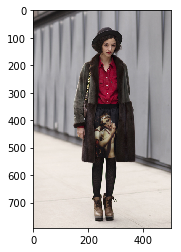

In [10]:
img = imread("data/ClothingAttributeDataset/test/000009.jpg")
plt.imshow(img)

In [10]:
pretrained_conv_model, _, _ = get_pretrained_model("vgg16", pop_last_pool_layer=True, use_gpu=use_gpu)

In [11]:
target_dims = get_attribute_dims(label_values_file)

In [12]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
                                # dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-266-2/",
                                labels_file, 
                                TRAIN_IMAGES_FOLDER, 
                                VALID_IMAGES_FOLDER, 
                                num_epochs=1, 
                                is_train=False,
                                use_gpu=use_gpu)

Processing Attribute: gender_GT
Processing Attribute: necktie_GT
Processing Attribute: placket_GT
Processing Attribute: scarf_GT
Processing Attribute: neckline_GT
Processing Attribute: category_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: pattern_GT
Processing Attribute: collar_GT
Processing Attribute: sleevelength_GT


In [15]:
# use_gpu = torch.cuda.is_available()

# def 
# if use_gpu:
#     pretrained_conv_model = pretrained_conv_model.cuda()
#     for model in attribute_models.values():
#         model.cuda()

In [15]:
label_values = load_label_values(label_values_file)

In [15]:
image_url = 'data/ClothingAttributeDataset/sample/000187.jpg'

In [16]:
image_features = image_loader(image_url, use_gpu=True)

In [17]:
image_features.size()

torch.Size([1, 3, 400, 266])

In [18]:
pretrained_features = pretrained_conv_model(image_features)

In [19]:
pretrained_features.size()

torch.Size([1, 512, 25, 16])

In [19]:
# Dense Layer FC

# results = predict_attributes(image_url, alexnet_conv, attribute_models, 
#                             attribute_idx_map=label_values["idx_to_names"],
#                             flatten_pretrained_out=True, 
#                             use_gpu=use_gpu)

In [20]:
image_url

'data/ClothingAttributeDataset/sample/000175.jpg'

In [ ]:
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

In [13]:
from preprocessing import default_loader, image_loader, get_transforms, make_dsets
from classifiers import predict_model
from torch.autograd import Variable

In [43]:
image_features[0]

torch.Size([3, 400, 266])

In [15]:
data_loaders = make_dsets('data/ClothingAttributeDataset/sample', labels_file, "neckline_GT", batch_size=32, num_workers=4, 
               is_train=False, shuffle=False)

In [16]:
import torch.utils.data as data

class AttributePredictDataset(data.Dataset):
    
    def __init__(self, image_url, transform=None, target_transform=None, loader=default_loader):

        super().__init__()
        
        self.image_url = image_url
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        
    def __getitem__(self, index):
        img = self.loader(self.image_url)
        target = 0
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return self.image_url, img, target

    def __len__(self):
        return 1

In [29]:
image_url = 'data/ClothingAttributeDataset/sample/000175.jpg'

In [19]:
image_loader(image_url).size()

torch.Size([1, 3, 400, 266])

In [30]:
predict_attributes(image_url, pretrained_conv_model, attribute_models, flatten_pretrained_out=False)

torch.Size([1, 3, 400, 266])
Predicting skin_exposure_GT
Predicting sleevelength_GT
Predicting collar_GT
Predicting necktie_GT
Predicting placket_GT
Predicting pattern_GT
Predicting scarf_GT
Predicting category_GT
Predicting neckline_GT
Predicting gender_GT


{'category_GT': (6, 0.17717944),
 'collar_GT': (1, 0.68600774),
 'gender_GT': (1, 0.68685842),
 'neckline_GT': (0, 0.50104755),
 'necktie_GT': (0, 0.92583376),
 'pattern_GT': (4, 0.57684553),
 'placket_GT': (1, 0.72161978),
 'scarf_GT': (0, 0.97431809),
 'skin_exposure_GT': (0, 0.98118109),
 'sleevelength_GT': (2, 0.92928863)}

In [31]:
image_features = image_loader(image_url)
pretrained_features = predict_model(pretrained_conv_model, image_features, flatten=False)
outputs = predict_model(attribute_models["neckline_GT"], pretrained_features)
pred_prob, pred_class = outputs.data.max(1)  
print(outputs.data.max(1))
print(np.exp(pred_prob.cpu().numpy().flatten()[0]), pred_class)

(
-0.6911
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, 
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
)
0.501048 
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]



In [32]:

image_dset = AttributePredictDataset(image_url, transform=get_transforms(is_train=True))

dset_loader = data.DataLoader(image_dset, batch_size=32,
                                shuffle=False)

for batch_files, inputs, labels in dset_loader:
#     print(batch_files, labels)
    inputs = Variable(inputs.cuda())
    pretrained_features2 = pretrained_conv_model(inputs)
    outputs = attribute_models["neckline_GT"](pretrained_features2)
    preds_proba, preds = outputs.data.max(1)
    print(outputs.data.max(1))
    print(preds_proba, np.exp(preds_proba.cpu().numpy().flatten()[0]))

(
-0.6911
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, 
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
)

-0.6911
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
 0.501048


In [35]:
images, image_features, labels = next(iter(data_loaders))
image_features = Variable(image_features.cuda())

In [25]:
# image_features = (get_transforms()(image)).unsqueeze(0).cuda()

In [36]:
pretrained_features = pretrained_conv_model(image_features)

In [37]:
outputs = attribute_models["neckline_GT"](pretrained_features)

In [38]:
image_features.size()

torch.Size([3, 3, 400, 266])

In [39]:
images

('data/ClothingAttributeDataset/sample/000187.jpg',
 'data/ClothingAttributeDataset/sample/000199.jpg',
 'data/ClothingAttributeDataset/sample/000175.jpg')

In [40]:
outputs.data


-0.0392 -4.1517 -3.7865
-2.4619 -0.3787 -1.4697
-1.3400 -0.5238 -1.9252
[torch.cuda.FloatTensor of size 3x3 (GPU 0)]

In [16]:
results = predict_attributes(image_url, pretrained_conv_model, attribute_models, 
                            attribute_idx_map=label_values["idx_to_names"],
                            flatten_pretrained_out=False, 
                            use_gpu=use_gpu)

Predicting neckline_GT
Predicting category_GT
Predicting gender_GT
Predicting collar_GT
Predicting skin_exposure_GT
Predicting sleevelength_GT
Predicting placket_GT
Predicting pattern_GT
Predicting necktie_GT
Predicting scarf_GT


In [17]:
results

{'category_GT': array([[-1.74185216, -1.93918228, -2.47495174, -1.73868656, -1.92915595,
         -2.31653643, -1.73059225]], dtype=float32),
 'collar_GT': array([[-1.15838718, -0.37686625]], dtype=float32),
 'gender_GT': array([[-1.16109991, -0.37562713]], dtype=float32),
 'neckline_GT': array([[-0.69105434, -1.09543717, -1.80448568]], dtype=float32),
 'necktie_GT': array([[-0.0770607 , -2.60144615]], dtype=float32),
 'pattern_GT': array([[-3.288342  , -2.87000704, -3.03383303, -2.93606281, -0.55018055,
         -1.47869468]], dtype=float32),
 'placket_GT': array([[-1.27876723, -0.32625693]], dtype=float32),
 'scarf_GT': array([[-0.02601743, -3.66196966]], dtype=float32),
 'skin_exposure_GT': array([[-0.01899827, -3.97289681]], dtype=float32),
 'sleevelength_GT': array([[-3.79770517, -3.03054547, -0.07333589]], dtype=float32)}

In [23]:
results

{'category_GT': array([[-1.74185205, -1.9391824 , -2.47495222, -1.73868668, -1.92915571,
         -2.31653643, -1.73059225]], dtype=float32),
 'collar_GT': array([[-1.15838683, -0.3768664 ]], dtype=float32),
 'gender_GT': array([[-1.16109979, -0.3756271 ]], dtype=float32),
 'neckline_GT': array([[-0.69105422, -1.09543729, -1.80448604]], dtype=float32),
 'necktie_GT': array([[-0.07706058, -2.60144544]], dtype=float32),
 'pattern_GT': array([[-3.28834248, -2.87000704, -3.03383279, -2.93606257, -0.55018079,
         -1.47869444]], dtype=float32),
 'placket_GT': array([[-1.27876723, -0.32625693]], dtype=float32),
 'scarf_GT': array([[-0.02601743, -3.66197014]], dtype=float32),
 'skin_exposure_GT': array([[-0.01899827, -3.97289705]], dtype=float32),
 'sleevelength_GT': array([[-3.79770613, -3.03054476, -0.07333589]], dtype=float32)}

In [30]:
results

{'category_GT': ('Dress', 0.17717944),
 'collar_GT': ('Has Collar', 0.68600774),
 'gender_GT': ('Is Female', 0.68685842),
 'neckline_GT': ('V-shape', 0.50104755),
 'pattern_GT': ('Solid', 0.57684553),
 'placket_GT': ('Has Placket', 0.72161978),
 'sleevelength_GT': ('Long sleeves', 0.92928863)}

In [36]:
np.exp(-0.82337499)

0.4389477076378599

In [ ]:
 'neckline_GT': {'accuracy': 0.3333333333333333,
  'input_files': array(['data/ClothingAttributeDataset/sample/000187.jpg',
         'data/ClothingAttributeDataset/sample/000199.jpg',
         'data/ClothingAttributeDataset/sample/000175.jpg'], 
        dtype='<U47'),
  'loss': 1.165188193321228,
  'y_pred': array([ 0.,  1.,  0.]),
  'y_pred_proba': array([-0.01920366, -0.5715282 , -0.82337499]),
  'y_true': array([ 0.,  0.,  2.])},

## Evaluate Test Set

In [16]:
attribute_models.keys()

dict_keys(['skin_exposure_GT', 'necktie_GT', 'collar_GT', 'pattern_GT', 'gender_GT', 'sleevelength_GT', 'neckline_GT', 'category_GT', 'scarf_GT', 'placket_GT'])

In [13]:
from classifiers import evaluate_model, test_models

In [53]:
eval_results = {}
for target, model in attribute_models.items():
    eval_results[target] = evaluate_model(attribute_models[target], pretrained_conv_model, target, 
                                                labels_file,
                                                VALID_IMAGES_FOLDER,
                                                batch_size=32, num_workers=4, 
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False)

In [16]:
(eval_results["category_GT"]["y_pred"] == eval_results["category_GT"]["y_true"]).sum() / len(eval_results["category_GT"]["y_pred"])

0.74025974025974028

In [54]:
test_results = {}
for target, model in attribute_models.items():
    test_results[target] = evaluate_model(attribute_models[target], pretrained_conv_model, target, 
                                                labels_file,
                                                TEST_IMAGES_FOLDER,
                                                batch_size=32, num_workers=4,
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False)

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn

In [64]:
for attrib_name, results in eval_results.items():
    print(attrib_name)
    print(confusion_matrix(results["y_true"], results["y_pred"]))
#     print("Accuracy: {:.2%}".format((results["y_pred"] == results["y_true"]).sum() / len(results["y_true"])))

scarf_GT
[[205   8]
 [  9  21]]
necktie_GT
[[216   9]
 [  9  24]]
placket_GT
[[ 84  11]
 [ 12 157]]
neckline_GT
[[77  4  3]
 [15 57  1]
 [ 9  9 23]]
category_GT
[[19  0  0  1  1  0  0]
 [ 4  6  2  2  2  0  0]
 [ 1  0 21  0  0  0  0]
 [ 2  1  0 17  1  0  2]
 [ 0  0  0  1 37  0  0]
 [ 1  0  0  0  0  8  4]
 [ 1  0  0  0  0  0 31]]
skin_exposure_GT
[[216   3]
 [  5  29]]
pattern_GT
[[  5   1   2   0   2   0]
 [  0  17   0   0   4   0]
 [  0   0   9   0   3   1]
 [  0   0   5   9   4   1]
 [  0   1   0   0 157   2]
 [  0   1   2   0  36  16]]
gender_GT
[[102  12]
 [  3 146]]
collar_GT
[[ 79  13]
 [  8 123]]
sleevelength_GT
[[ 29   0   0]
 [  2  46   5]
 [  0   3 185]]


In [62]:
for attrib_name, results in test_results.items():
    print(attrib_name)
    print(confusion_matrix(results["y_true"], results["y_pred"]))
#     print("Accuracy: {:.2%}".format((results["y_pred"] == results["y_true"]).sum() / len(results["y_true"])))

scarf_GT
[[132  10]
 [  5  19]]
necktie_GT
[[153   8]
 [  0  16]]
placket_GT
[[58  8]
 [20 92]]
neckline_GT
[[54  9  0]
 [ 8 42  1]
 [ 3  5 18]]
category_GT
[[11  0  6  3  0  0  0]
 [ 0  2  3  0  3  0  0]
 [ 0  0 15  0  0  0  0]
 [ 1  0  0 16  2  0  0]
 [ 0  0  0  0 17  0  0]
 [ 0  0  1  0  0  3  0]
 [ 0  0  0  1  0  0 30]]
skin_exposure_GT
[[140   4]
 [  3  17]]
pattern_GT
[[  2   0   0   0   0   1]
 [  0  13   1   0   2   1]
 [  0   1   4   0   3   1]
 [  0   0   1   8   2   1]
 [  0   0   0   0 101   3]
 [  0   0   0   1  26  14]]
gender_GT
[[67 15]
 [ 5 98]]
collar_GT
[[56  3]
 [ 9 78]]
sleevelength_GT
[[ 20   0   0]
 [  0  38   1]
 [  1   1 122]]


In [59]:
for attrib_name, results in test_results.items():
    print(attrib_name)
    print("Accuracy: {:.2%}".format((results["y_pred"] == results["y_true"]).sum() / len(results["y_true"])))

scarf_GT
Accuracy: 93.00%
necktie_GT
Accuracy: 93.02%
placket_GT
Accuracy: 91.29%
neckline_GT
Accuracy: 79.29%
category_GT
Accuracy: 84.24%
skin_exposure_GT
Accuracy: 96.84%
pattern_GT
Accuracy: 76.62%
gender_GT
Accuracy: 94.30%
collar_GT
Accuracy: 90.58%
sleevelength_GT
Accuracy: 96.30%


In [17]:
(test_results["category_GT"]["y_pred"] == test_results["category_GT"]["y_true"]).sum() / len(test_results["category_GT"]["y_pred"])

0.81132075471698117

In [16]:
sample_results = {}
for target, model in attribute_models.items():
    if target == "neckline_GT":
        print(evaluate_model(attribute_models[target], pretrained_conv_model, target, 
                                                labels_file,
                                                "data/ClothingAttributeDataset/sample",
                                                batch_size=32, num_workers=4,
                                                use_gpu=use_gpu,
                                                flatten_pretrained_out=False))

{'accuracy': 0.3333333333333333, 'y_true': array([ 0.,  0.,  2.]), 'input_files': array(['data/ClothingAttributeDataset/sample/000187.jpg',
       'data/ClothingAttributeDataset/sample/000199.jpg',
       'data/ClothingAttributeDataset/sample/000175.jpg'], 
      dtype='<U47'), 'y_pred': array([ 0.,  1.,  0.]), 'y_pred_proba': array([-0.01446557, -0.8060196 , -0.51870656]), 'loss': 1.0094143152236938}


In [16]:
test_models(attribute_models, pretrained_conv_model, 'data/ClothingAttributeDataset/sample/000187.jpg',
            attribute_idx_map=label_values["idx_to_names"])

{'category_GT': {'pred_class': 'Outerwear',
  'pred_idx': 3,
  'pred_prob': 0.95346075},
 'collar_GT': {'pred_class': 'Has Collar',
  'pred_idx': 1,
  'pred_prob': 0.94504762},
 'gender_GT': {'pred_class': 'Is Female',
  'pred_idx': 1,
  'pred_prob': 0.93196648},
 'neckline_GT': {'pred_class': 'V-shape',
  'pred_idx': 0,
  'pred_prob': 0.98563856},
 'pattern_GT': {'pred_class': 'Solid', 'pred_idx': 4, 'pred_prob': 0.82243913},
 'placket_GT': {'pred_class': 'Has Placket',
  'pred_idx': 1,
  'pred_prob': 0.99248105},
 'sleevelength_GT': {'pred_class': 'Long sleeves',
  'pred_idx': 2,
  'pred_prob': 0.99963909}}

In [17]:
import pandas as pd

In [19]:
results = test_models(attribute_models, pretrained_conv_model, 'data/ClothingAttributeDataset/sample/000187.jpg',
            attribute_idx_map=label_values["idx_to_names"])

In [31]:
df = pd.DataFrame(results).T

In [32]:
df["pred_prob"] = df["pred_prob"].astype(float)


category_GT        0.953461
collar_GT          0.945048
gender_GT          0.931966
neckline_GT        0.985639
pattern_GT         0.822439
placket_GT         0.992481
sleevelength_GT    0.999639
Name: pred_prob, dtype: float64

sample_results

In [27]:
pred_proba, preds = outputs.data.max(1)

In [32]:
preds.cpu().numpy().flatten()

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0])

In [17]:
a = np.array([1, 2, 3])
b = np.array([3, 4])

In [20]:
np.concatenate([a, b])

array([1, 2, 3, 3, 4])

In [15]:
eval_accuracy

247

In [16]:
labels.size()

torch.Size([32])

In [ ]:
 = create_attributes_model(, 512, pretrained_conv_model,
                                target_dims, 
                                # dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-266-2/",
                                labels_file, 
                                TRAIN_IMAGES_FOLDER, 
                                VALID_IMAGES_FOLDER, 
                                num_epochs=1, 
                                is_train=False,
                                use_gpu=use_gpu)

## Visualize FCN

In [23]:
import scipy.misc

In [49]:
## Take an Example Image
image_url = "data/ClothingAttributeDataset/images/000169.jpg"

In [50]:
results_base = test_models(attribute_models, pretrained_conv_model, image_url,
            attribute_idx_map=label_values["idx_to_names"])

In [51]:
results = test_models(attribute_models, pretrained_conv_model, image_url,
                      attribute_idx_map=label_values["idx_to_names"], return_last_conv_layer=True)

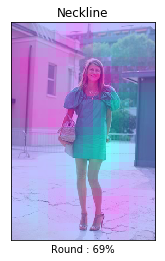

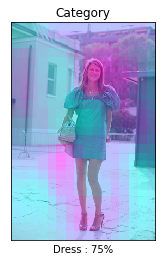

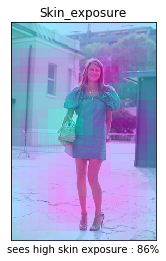

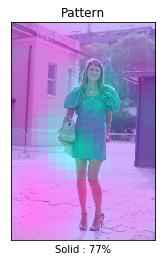

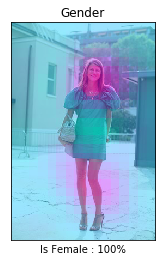

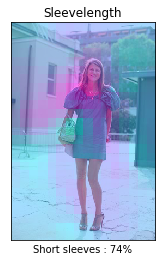

In [52]:
for attrib_name, values in results.items():
    
    plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
    plt.imshow(scipy.misc.imresize(values["conv_layer"], (400, 266), interp='nearest'), 
               alpha=0.5, cmap="cool")
    attrib_name = attrib_name[:-3].capitalize()
    title_prob = "{:.0%}".format(values["pred_prob"])
    plt.title(attrib_name)
#     plt.axis("image")
    plt.yticks([], [])
    plt.xticks([], [])
    plt.xlabel(str(values["pred_class"]) + " : " + title_prob)

    plt.show()

In [36]:
conv_out = results["category_GT"]["conv_layer"][0, 5]

In [ ]:
## Extract Features

conv_layer_out = attribute_models["sleevelength_GT"].conv_model(pretrained_features)

In [49]:
conv_arr2 = conv_layer_out[0].data.cpu().numpy()

In [41]:
conv_arr = conv_layer_out[0].data.cpu().numpy()

In [42]:
np.mean(conv_arr2, axis=(1, 2))

array([-1.37030685, -0.64836776,  2.07857776], dtype=float32)

In [50]:
np.mean(conv_arr, axis=(1, 2))

array([-1.37030685, -0.64836776,  2.07857776], dtype=float32)

In [28]:
from torchvision import transforms

In [29]:
image_features.size()

torch.Size([1, 3, 224, 224])

In [55]:
# transforms.ToPILImage()(image_features[0].data.cpu())

In [38]:
image_features[0].data.cpu().numpy().shape

(3, 400, 266)

In [54]:
# plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))

In [75]:
conv_out = conv_layer_out[0].data.cpu().numpy()

In [67]:
conv_out_exp = np.exp(conv_out)

In [68]:
conv_out_sum = np.sum(conv_out_exp, 0)

In [69]:
conv_out_smax = (conv_out_exp / conv_out_sum)

In [37]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out[3], (400, 266), interp='nearest'), 
           alpha=0.5, cmap="cool")

NameError: name 'scipy' is not defined

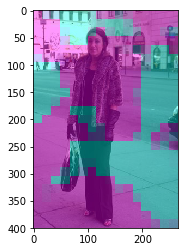

In [71]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out_smax[2], (400, 266), interp='nearest'), 
           alpha=0.4, cmap="cool")

## Confusion Matrix

In [57]:
for data in dset_loaders["train"]:
    inputs, labels = data
    if use_gpu:
        X = Variable(inputs.cuda())
    else:
        X = Variable(inputs)
    results = model(X)
    if use_gpu:
        results = results.cpu()
    break

NameError: name 'dset_loaders' is not defined

In [25]:
data = [{"placket_GT": ["Has Placket", "1.0%"], "sleevelength_GT": ["Long sleeves", "1.0%"], "category_GT": ["Suit", "1.0%"], "pattern_GT": ["Solid", "1.0%"], "neckline_GT": ["V-shape", "1.0%"], "collar_GT": ["Has Collar", "1.0%"], "gender_GT": ["Is Male", "1.0%"]}]

In [26]:
import pandas as pd

In [28]:
data

[{'category_GT': ['Suit', '1.0%'],
  'collar_GT': ['Has Collar', '1.0%'],
  'gender_GT': ['Is Male', '1.0%'],
  'neckline_GT': ['V-shape', '1.0%'],
  'pattern_GT': ['Solid', '1.0%'],
  'placket_GT': ['Has Placket', '1.0%'],
  'sleevelength_GT': ['Long sleeves', '1.0%']}]

In [ ]:
for 

In [31]:
df = pd.DataFrame(data[0]).T

In [32]:
df.columns = ["Prediction", "Probability"]

In [35]:
df.index = df.index.str.replace("_GT", "").str.capitalize()

In [36]:
df

,Prediction,Probability
Category,Suit,1.0%
Collar,Has Collar,1.0%
Gender,Is Male,1.0%
Neckline,V-shape,1.0%
Pattern,Solid,1.0%
Placket,Has Placket,1.0%
Sleevelength,Long sleeves,1.0%
